In [2]:
from numba.experimental import jitclass

from numba import njit, float64
from pylab import np, plt

plt.style.use('ggplot')

In [157]:
#### Class definition 
@jitclass(
    spec=[
        # simulation time step and common matrix initialization
        ('tsim_machine', float64),
        ('tsim_controller',float64),
        ('tsim_stop',float64),
        ('I_2x2',float64[:,:]),
        ('J_2x2',float64[:,:]),
        ('ThetaTilde',float64),
    ]
)
class SimParam:
    def __init__(self,tsim_machine,tsim_controller,tsim_stop):
        self.tsim_machine = tsim_machine
        self.tsim_controller = tsim_controller
        self.tsim_stop = tsim_stop
        self.I_2x2 = np.eye(2,dtype=np.float64)
        self.J_2x2 = np.array([[0,-1],[1,0]],dtype=np.float64)

@jitclass(
    spec=[
        # synchronous machine name plate of electrical parameters
        ('Rs', float64),
        ('Ld',float64),
        ('Lq',float64),
        ('Lmat',float64[:,:]),
        ('Lmat_inv',float64[:,:]),
        # ('PsiPM',float64), the flux DC component is ignored in small signal model

        # the simulation only focus on position error compensation which caused by parameter mismatch.
        # the rotor position can be observed by regular sensorless control method.
        ('OmegaE',float64),
        ('ThetaError',float64),
        
        # machine state vectors in synchronous rotating frame
        ('udq',float64[:,:]),
        ('idq',float64[:,:]),

        # machine state vectors in misaligned synchronous rotating frame 
        ('ugd',float64[:,:]),
        ('igd',float64[:,:]),


    ]
)

class ACMachineSM_SmallSignalModel:
    def __init__(self,
                 init_Rs = 0.8,
                 init_Ld = 1.6e-3,
                 init_Lq = 3.2e-3,
                 init_OmegaE = 2 * np.pi * 50,
                 init_ThetaError = np.pi/6):
        self.Rs = init_Rs
        self.Ld = init_Ld
        self.Lq = init_Lq
        self.Lmat = np.array([[self.Ld,0],[0,self.Lq]],dtype=np.float64)
        self.Lmat_inv = np.array([[1/self.Ld,0],[0,1/self.Lq]],dtype=np.float64)

        self.OmegaE = init_OmegaE
        self.ThetaError = init_ThetaError

        self.udq = np.zeros((2,1),dtype=np.float64)
        self.idq = np.zeros((2,1),dtype=np.float64)

        self.ugd = np.zeros((2,1),dtype=np.float64)
        self.igd = np.zeros((2,1),dtype=np.float64)

@jitclass(
    spec=[
        ('INJ_UDQmis_HF',float64[:,:]),
        ('CMD_umdh_mis',float64),
        ('CMD_umqh_mis',float64),
        ('ThetaH',float64),
        ('OmegaH',float64),
    ]
)
class DSPController:
    def __init__(self,
                 CMD_umdh_mis = 2.0,
                 CMD_umqh_mis = 2.0,
                 OmegaH = 2 * np.pi * 100):
        self.INJ_UDQmis_HF = np.zeros((2,1),dtype=np.float64)

        self.CMD_umdh_mis = CMD_umdh_mis
        self.CMD_umqh_mis = CMD_umqh_mis
        self.ThetaH = 0.0
        self.OmegaH = OmegaH


@jitclass(
        spec=[
            ('igdh_hat',float64[:,:]),
            ('Rs_hat',float64),
            ('Lgg_hat',float64), #Lgg stands for L_{\gamma\gamma}
            ('Lgd_hat',float64), #Lgg stands for L_{\gamma\delta}
            ('Ldd_hat',float64), #Ldd stands for L_{\delta\delta}
            ('ThetaError_hat',float64),
            #estimated parameters gains
            ('K_Rs',float64),
            ('K_L',float64),
            ('K_i',float64),
            ('K_theta',float64),
        ]
)
class Observer:
    def __init__(self,
                Rs_init = 0.5,
                Lgg_hat_init = 1.6e-3 * 0.8,
                Lgd_hat_init = 0,
                Ldd_hat_init = 3.2e-3 * 0.8,
                K_Rs = 1e1,
                K_L = 5e-4,
                K_i = 1e-3,
                K_theta = 1e-5):
        self.Rs_hat = Rs_init
        self.Lgg_hat = Lgg_hat_init
        self.Lgd_hat = Lgd_hat_init
        self.Ldd_hat = Ldd_hat_init
        self.K_Rs = K_Rs
        self.K_L = K_L
        self.K_i = K_i
        self.K_theta = K_theta
        self.ThetaError_hat = 0.0

        self.igdh_hat = np.zeros((2,1),dtype=np.float64)


@njit(nogil=True)
def AdaptiveSystemANDOptimizer(simparam:SimParam,smparam:ACMachineSM_SmallSignalModel,Obparam:Observer,ctrlparam:DSPController):
    i_hat = Obparam.igdh_hat

    i = Park(smparam.igd,Obparam.ThetaError_hat)
    i_tilde = i_hat - i

    # u = ctrlparam.INJ_UDQmis_HF
    u = Park(ctrlparam.INJ_UDQmis_HF,Obparam.ThetaError_hat)
    # u = Park(u,-ctrlparam.OmegaH * simparam.tsim_controller * 0.5)

    L_hat = np.array([[Obparam.Lgg_hat,Obparam.Lgd_hat],[Obparam.Lgd_hat,Obparam.Ldd_hat]])
    Temp = -1.0/(Obparam.Lgg_hat * Obparam.Ldd_hat - Obparam.Lgd_hat ** 2)
    L_hat_inv = np.array([[-Temp * Obparam.Ldd_hat,Temp * Obparam.Lgd_hat],[Temp * Obparam.Lgd_hat,-Temp * Obparam.Lgg_hat]])

    A = -(simparam.I_2x2 * Obparam.Rs_hat + smparam.OmegaE * matrix_dot(simparam.J_2x2,L_hat))
    A = matrix_dot(L_hat_inv,A)
    B = L_hat_inv
    i_hat_dot = matrix_dot(A,i_hat) + matrix_dot(B,u)

    Phi = simparam.I_2x2 + simparam.tsim_controller * A + 0.5 * simparam.tsim_controller**2 * matrix_dot(A,A)
    G = matrix_dot(B,simparam.I_2x2 + 0.5 * simparam.tsim_controller * A) * simparam.tsim_controller

    Obparam.Rs_hat += simparam.tsim_controller * Obparam.K_Rs * (i_tilde[0,0] * i_hat[0,0] + i_tilde[1,0] * i_hat[1,0])
    Obparam.Lgg_hat += simparam.tsim_controller * Obparam.K_L * (smparam.OmegaE * i_hat[0,0] * i_tilde[1,0] + i_hat_dot[0,0] * i_tilde[0,0])
    Obparam.Ldd_hat += simparam.tsim_controller * Obparam.K_L * (-smparam.OmegaE * i_hat[1,0] * i_tilde[0,0] + i_hat_dot[1,0] * i_tilde[1,0])
    Obparam.Lgd_hat += simparam.tsim_controller * Obparam.K_L * (-smparam.OmegaE * i_hat[0,0] * i_tilde[0,0] + i_hat_dot[1,0] * i_tilde[0,0] + smparam.OmegaE * i_hat[1,0] * i_tilde[1,0] + i_hat_dot[0,0] * i_tilde[1,0])
   
    Obparam.igdh_hat = matrix_dot(Phi,i_hat) + matrix_dot(G,u - smparam.OmegaE * i_tilde * Obparam.K_i)
    if Obparam.Lgd_hat > 0:
        Obparam.ThetaError_hat += Obparam.K_theta
    else:
        Obparam.ThetaError_hat -= Obparam.K_theta

    return Obparam

# matrix dot multiplication(the numba only supports 1-dim array multiplication)
@njit(nogil=True)
def matrix_dot(mat1,mat2):
    s = 0
    mat = np.empty(shape=(mat1.shape[0], mat2.shape[1]), dtype=mat1.dtype)
    for i in range(mat1.shape[0]):
        for j in range(mat2.shape[1]):
            s = 0
            for k in range(mat2.shape[0]):
                s += mat1[i,k] * mat2[k,j]
            mat[i,j] = s
    return mat

#park transformation aligned from misaligned d-axis(gamma-axis) to d-axis
@njit(nogil=True)
def Park(dq_mis,Theta):
    dq = np.zeros((2,1),dtype=np.float64)
    dq[0,0] = dq_mis[0,0] * np.cos(Theta) + dq_mis[1,0] * np.sin(Theta)
    dq[1,0] = -dq_mis[0,0] * np.sin(Theta) + dq_mis[1,0] * np.cos(Theta)
    return dq

#First order Euler discretization
@njit(nogil=True)
def ODE_Machine_1st(simparam:SimParam,smparam:ACMachineSM_SmallSignalModel,ctrlparam:DSPController):
    smparam.ugd = ctrlparam.INJ_UDQmis_HF
    smparam.udq = Park(ctrlparam.INJ_UDQmis_HF,smparam.ThetaError)
    psidq = matrix_dot(smparam.Lmat,smparam.idq)
    idq_dot = smparam.udq - smparam.Rs * smparam.idq - smparam.OmegaE * matrix_dot(simparam.J_2x2,psidq)
    idq_dot = matrix_dot(smparam.Lmat_inv,idq_dot)
    smparam.idq += idq_dot * simparam.tsim_machine
    smparam.igd = Park(smparam.idq,smparam.ThetaError * -1)
    return smparam

#signal injection for parameters PE condition to realize simultaneous estimation
@njit(nogil=True)
def DSP_HFI(simparam:SimParam,smparam:ACMachineSM_SmallSignalModel,ctrlparam:DSPController):
    temp = matrix_dot(simparam.J_2x2,smparam.Lmat)
    ctrlparam.INJ_UDQmis_HF[0,0] = ctrlparam.CMD_umdh_mis * np.sin(ctrlparam.ThetaH)
    ctrlparam.INJ_UDQmis_HF[1,0] = ctrlparam.CMD_umqh_mis * np.cos(ctrlparam.ThetaH)
    ctrlparam.ThetaH += ctrlparam.OmegaH * simparam.tsim_controller
    
    return ctrlparam

#machine simulation section
@njit(nogil=True)
def ACMSimPyIncremental(simparam:SimParam,smparam:ACMachineSM_SmallSignalModel,ctrlparam:DSPController,Obparam:Observer):
    down_sampling = int(simparam.tsim_controller/simparam.tsim_machine)
    machine_times = np.arange(0,simparam.tsim_stop,simparam.tsim_machine)
    ctrl_times = np.arange(0,simparam.tsim_stop,simparam.tsim_controller)
    # watch_data_machine = np.zeros((13, len(machine_times)))
    watch_data_ctrl    = np.zeros((12,  len(ctrl_times   )))
    jj = 0; watch_index_machine = 0; watch_index_ctrl = 0
    for ii in range(len(machine_times)):
        t = machine_times[ii]
        jj += 1
        if jj >= down_sampling:
            jj = 0

            ctrlparam = DSP_HFI(simparam,smparam,ctrlparam)
            Obparam = AdaptiveSystemANDOptimizer(simparam,smparam,Obparam,ctrlparam)

            watch_data_ctrl[0 ][watch_index_ctrl] = smparam.idq[0,0]
            watch_data_ctrl[1 ][watch_index_ctrl] = smparam.idq[1,0]
            watch_data_ctrl[2 ][watch_index_ctrl] = Obparam.igdh_hat[0,0]
            watch_data_ctrl[3 ][watch_index_ctrl] = Obparam.igdh_hat[1,0]
            watch_data_ctrl[4 ][watch_index_ctrl] = Obparam.Rs_hat
            watch_data_ctrl[5 ][watch_index_ctrl] = Obparam.Lgg_hat * 1e3
            watch_data_ctrl[6 ][watch_index_ctrl] = Obparam.Lgd_hat * 1e3
            watch_data_ctrl[7 ][watch_index_ctrl] = Obparam.Ldd_hat * 1e3
            watch_index_ctrl += 1
        smparam = ODE_Machine_1st(simparam,smparam,ctrlparam)
    return ctrl_times,watch_data_ctrl


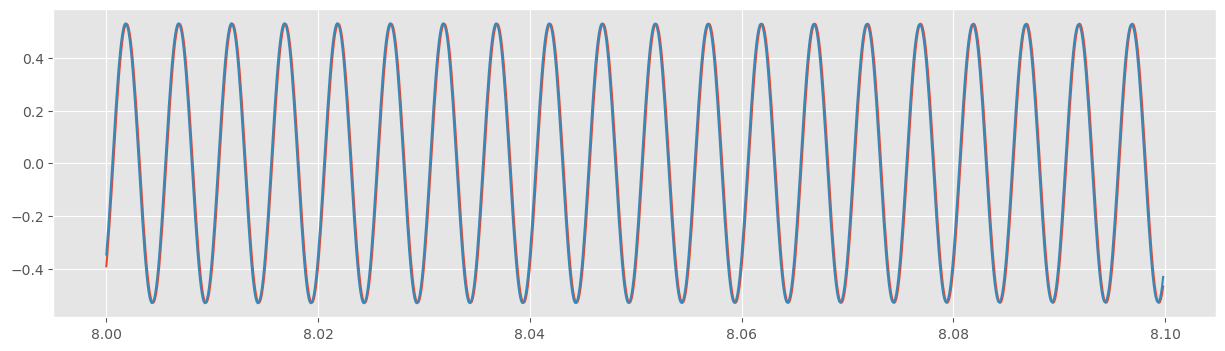

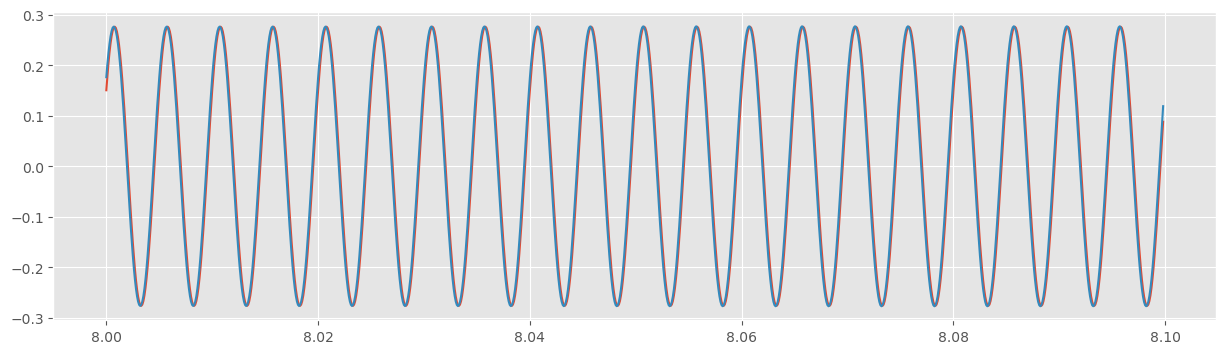

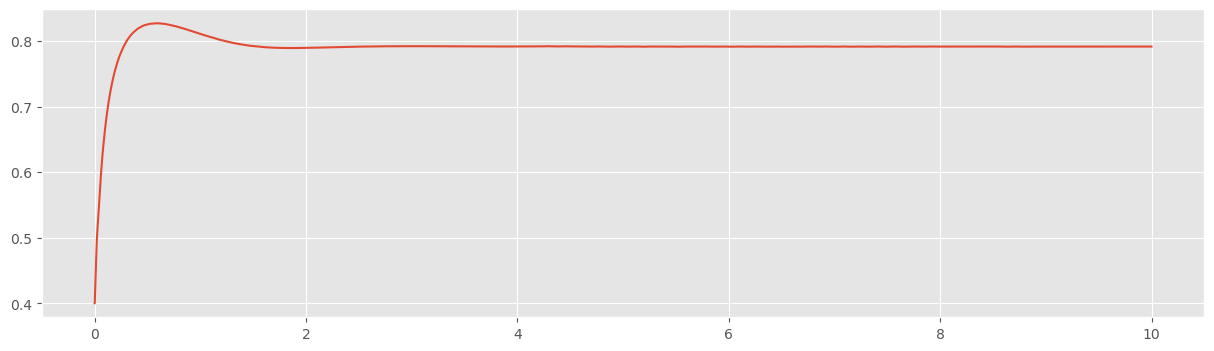

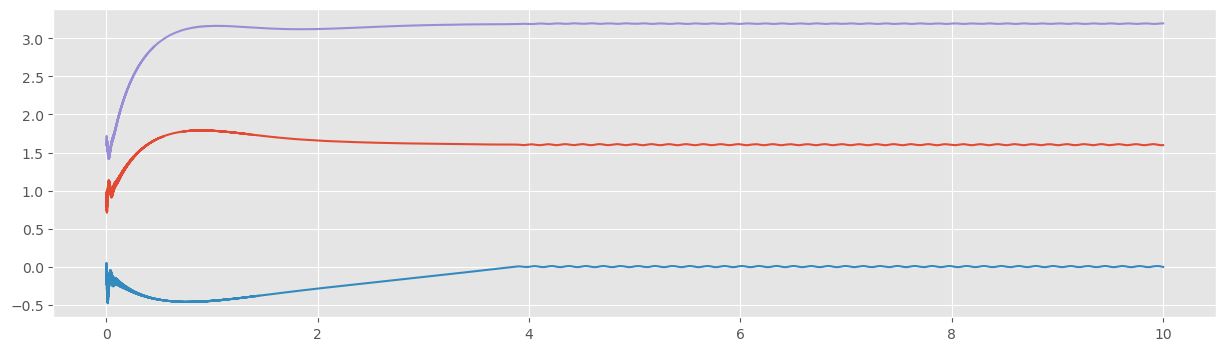

In [158]:
#without extra signal excitation
#parameter initialization 
simparam = SimParam(
    tsim_machine = 1e-6,
    tsim_controller = 1e-4,
    tsim_stop = 10)
spmsm_1st = ACMachineSM_SmallSignalModel(
                init_Rs = 0.8,
                init_Ld = 1.6e-3,
                init_Lq = 3.2e-3,
                init_OmegaE = 400 * 4/60 * 2 * np.pi,
                init_ThetaError = np.pi/8)

ctrl = DSPController(
                    CMD_umdh_mis = 1.0,
                    CMD_umqh_mis = 1.0,
                    OmegaH = 2 * np.pi * 200)
ob = Observer(
                Rs_init = 0.8 * 0.5,
                Lgg_hat_init = 1.6e-3 * 0.5,
                Lgd_hat_init = 0 * 0.5,
                Ldd_hat_init = 3.2e-3 * 0.5,
                K_Rs = 1e1,
                K_L = 5e-4,
                K_i = 1e-4,
                K_theta = -1e-5 #for spmsm, simply set K_theta to zero.
                )

ctrl_times,watch_data_ctrl = ACMSimPyIncremental(simparam,spmsm_1st,ctrl,ob)


ctrl_plot_start_time = 8
ctrl_plot_stop_time = 8.1
start_index = int(ctrl_plot_start_time/simparam.tsim_controller)
end_index = int(ctrl_plot_stop_time/simparam.tsim_controller)
plt.figure(figsize=(15,4))
plt.plot(ctrl_times[list(range(start_index,end_index))],watch_data_ctrl[0][list(range(start_index,end_index))])
plt.plot(ctrl_times[list(range(start_index,end_index))],watch_data_ctrl[2][list(range(start_index,end_index))])
plt.show()
plt.figure(figsize=(15,4))
plt.plot(ctrl_times[list(range(start_index,end_index))],watch_data_ctrl[1][list(range(start_index,end_index))])
plt.plot(ctrl_times[list(range(start_index,end_index))],watch_data_ctrl[3][list(range(start_index,end_index))])
plt.show()

ctrl_plot_start_time = 0
ctrl_plot_stop_time = 10
start_index = int(ctrl_plot_start_time/simparam.tsim_controller)
end_index = int(ctrl_plot_stop_time/simparam.tsim_controller)
plt.figure(figsize=(15,4))
plt.plot(ctrl_times[list(range(start_index,end_index))],watch_data_ctrl[4][list(range(start_index,end_index))])
plt.show()
plt.figure(figsize=(15,4))
plt.plot(ctrl_times[list(range(start_index,end_index))],watch_data_ctrl[5][list(range(start_index,end_index))])
plt.plot(ctrl_times[list(range(start_index,end_index))],watch_data_ctrl[6][list(range(start_index,end_index))])
plt.plot(ctrl_times[list(range(start_index,end_index))],watch_data_ctrl[7][list(range(start_index,end_index))])
plt.show()